In [3]:
#download data
!curl --create-dirs -o './data/data.csv' 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1390k  100 1390k    0     0  6014k      0 --:--:-- --:--:-- --:--:-- 6018k


In [1]:
#import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#load data:
df = pd.read_csv('./data/data.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.dtypes.longitude

dtype('float64')

In [4]:
# filter num and cat cols:
cat_cols = []
num_cols = []
target = 'median_house_value'
def filter_cat_num_cols(df, target):
    for col in df.columns:
        if df.dtypes[col] == 'object' and col != target:
            cat_cols.append(col)
        elif col != target:
            num_cols.append(col)
    return cat_cols, num_cols

cat_cols, num_cols = filter_cat_num_cols(df, target)

In [5]:
#fill spaces and - with underscore for cat columns:
for col in cat_cols:
    df[col] = df[col].str.replace(' ', '_').str.replace('-', '_').str.replace('<', '_')


In [6]:
#fill na with 0:
df.total_bedrooms.fillna(0, inplace=True)

In [7]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
# Apply log tranform to median_house_value.

df[target] = np.log1p(df[target])

In [9]:
# train/validation/test split with 60%/20%/20% distribution.
from sklearn.model_selection import train_test_split


train_full, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(train_full, test_size=0.25, random_state=1)

train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train_full shape: {train_full.shape}')
print(f'Train shape: {train.shape}')
print(f'Val shape: {val.shape}')
print(f'Test shape: {test.shape}')

y_train = train[target].values
y_val = val[target].values
y_test = test[target].values

del train[target]
del val[target]
del test[target]


Train_full shape: (16512, 10)
Train shape: (12384, 10)
Val shape: (4128, 10)
Test shape: (4128, 10)


In [10]:
# Use DictVectorizer to turn the dataframe into matrices.
from sklearn.feature_extraction import DictVectorizer

train_dict = train[cat_cols+num_cols].to_dict(orient='records')
val_dict = val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

### Question 1
Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

#### Which feature is used for splitting the data?

* ocean_proximity=INLAND
* total_rooms
* latitude
* population

In [11]:
# ANSWER is ocean_proximity=INLAND

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names()))



|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/ubuntu/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Question 2
Train a random forest model with these parameters:

```
n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
```

#### What's the RMSE of this model on validation?


* 0.05
* 0.25
* 0.55
* 0.85

In [12]:
#ANSWER: 0.25

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

preds = rf.predict(X_val)
rmse_score = mean_squared_error(y_val, preds, squared=False)
rmse_score

0.24522823511974276

### Question 3
Now let's experiment with the n_estimators parameter
```
Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
```
#### After which value of n_estimators does RMSE stop improving?

* 10
* 55
* 75
* 150


In [13]:
#ANSWER: 75

scores = []

for n in range(10, 201, 10):
    print(f'n_estimator : {n}')
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    preds = rf.predict(X_val)
    score = round(mean_squared_error(y_val, preds, squared=False), 3)
    scores.append((n, score))


n_estimator : 10
n_estimator : 20
n_estimator : 30
n_estimator : 40
n_estimator : 50
n_estimator : 60
n_estimator : 70
n_estimator : 80
n_estimator : 90
n_estimator : 100
n_estimator : 110
n_estimator : 120
n_estimator : 130
n_estimator : 140
n_estimator : 150
n_estimator : 160
n_estimator : 170
n_estimator : 180
n_estimator : 190
n_estimator : 200


In [14]:
cols = ['n_estimators', 'rmse_scores']
df_scores = pd.DataFrame(scores, columns = cols)
df_scores.head()

,n_estimators,rmse_scores
0,10,0.245
1,20,0.238
2,30,0.235
3,40,0.235
4,50,0.233


(0.231, 0.234)

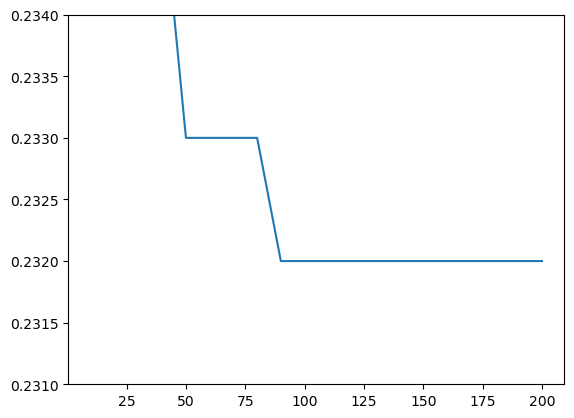

In [15]:
plt.plot(df_scores.n_estimators, df_scores.rmse_scores)
plt.ylim((0.231, 0.234))

### Question 4
Let's select the best max_depth:

```
Try different values of max_depth: [10, 15, 20, 25]
For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
Fix the random seed: random_state=1
```
#### What's the best max_depth:

* 10
* 15
* 20
* 25

In [18]:
#ANSWER: 25

scores = []
for n in range(10, 201, 10):
    for md in [10, 15, 20, 25]:
        rf = RandomForestRegressor(n_estimators=n, max_depth=md, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        preds = rf.predict(X_val)
        score = round(mean_squared_error(y_val, preds, squared=False), 3)
        scores.append((n, md, score))
        
        print(f'n_estimator : {n}, max_depth : {md} --> {score}')

n_estimator : 10, max_depth : 10 --> 0.255
n_estimator : 10, max_depth : 15 --> 0.246
n_estimator : 10, max_depth : 20 --> 0.246
n_estimator : 10, max_depth : 25 --> 0.247
n_estimator : 20, max_depth : 10 --> 0.252
n_estimator : 20, max_depth : 15 --> 0.24
n_estimator : 20, max_depth : 20 --> 0.239
n_estimator : 20, max_depth : 25 --> 0.239
n_estimator : 30, max_depth : 10 --> 0.251
n_estimator : 30, max_depth : 15 --> 0.238
n_estimator : 30, max_depth : 20 --> 0.236
n_estimator : 30, max_depth : 25 --> 0.236
n_estimator : 40, max_depth : 10 --> 0.251
n_estimator : 40, max_depth : 15 --> 0.237
n_estimator : 40, max_depth : 20 --> 0.235


KeyboardInterrupt: 

In [19]:
cols = ['n_estimators', 'max_depth', 'rmse_scores']
df_scores = pd.DataFrame(scores, columns = cols)
df_scores.head()

,n_estimators,max_depth,rmse_scores
0,10,10,0.255
1,10,15,0.246
2,10,20,0.246
3,10,25,0.247
4,20,10,0.252


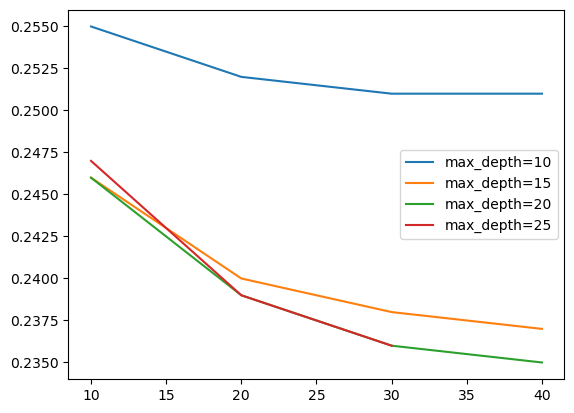

In [20]:
for md in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth==md]
    plt.plot(df_subset.n_estimators, df_subset.rmse_scores, label=f"max_depth={md}")
    
plt.legend()



### Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
```
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
```

Get the feature importance information from this model

What's the most important feature?

* total_rooms
* median_income
* total_bedrooms
* longitude

In [21]:
#ANSWER: median_income

rf = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1,
                            n_jobs=-1
                            )
rf.fit(X_train, y_train)

df_feature_importance = pd.DataFrame({'Features':dv.get_feature_names_out(), 'Importance': rf.feature_importances_})
df_feature_importance.sort_values(by='Importance', ascending=False)


,Features,Importance
4,median_income,0.363870
5,ocean_proximity=INLAND,0.310901
2,latitude,0.101012
3,longitude,0.096486
1,housing_median_age,0.033243
10,population,0.030148
12,total_rooms,0.020847
11,total_bedrooms,0.018909
0,households,0.016585
8,ocean_proximity=NEAR_OCEAN,0.005276


### Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost

Create DMatrix for train and validation

Create a watchlist

Train a model with these parameters for 100 rounds:
```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```
Now change eta first to 0.1 and then to 0.01

#### Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both gives same

In [40]:
# ANSWER: 0.3

import xgboost as xgb
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]


for eta in [0.01, 0.1, 0.3]:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
    }

    xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100, evals=watchlist, verbose_eval=10)

    preds = xgb_model.predict(dval)
    rmse_score = mean_squared_error(y_val, preds, squared=False)
    print(f'eta: {eta} --> rmse_score: {rmse_score}')
    print('#########################################')

[0]	train-rmse:11.48634	val-rmse:11.49225
[10]	train-rmse:10.38969	val-rmse:10.39532
[20]	train-rmse:9.39796	val-rmse:9.40346
[30]	train-rmse:8.50110	val-rmse:8.50645
[40]	train-rmse:7.69008	val-rmse:7.69524
[50]	train-rmse:6.95672	val-rmse:6.96171
[60]	train-rmse:6.29360	val-rmse:6.29841
[70]	train-rmse:5.69400	val-rmse:5.69854
[80]	train-rmse:5.15187	val-rmse:5.15621
[90]	train-rmse:4.66171	val-rmse:4.66589
[99]	train-rmse:4.26092	val-rmse:4.26496
eta: 0.01 --> rmse_score: 4.264961152048471
#########################################
[0]	train-rmse:10.44372	val-rmse:10.44938
[10]	train-rmse:3.65741	val-rmse:3.66135
[20]	train-rmse:1.30499	val-rmse:1.31054
[30]	train-rmse:0.51144	val-rmse:0.52189
[40]	train-rmse:0.27984	val-rmse:0.30053
[50]	train-rmse:0.22614	val-rmse:0.25334
[60]	train-rmse:0.21035	val-rmse:0.24189
[70]	train-rmse:0.20116	val-rmse:0.23684
[80]	train-rmse:0.19384	val-rmse:0.23398
[90]	train-rmse:0.18794	val-rmse:0.23206
[99]	train-rmse:0.18329	val-rmse:0.23054
eta: 0.1